# Potential temperature at 2m and 10m

Need to somehow estimate potential temperature at the heights I have reference CSAT data at. Previous iterations of this work used wind and temperature observations that were dislocated from each other veritcally. Additionally, none of these observational values came from the level at which the reference CSATs are situated, forcing me to rely on the constant flux with height assumption. We know that this assumption is broken at SCP, likely because of frequent cold pools. That said, I end up using a linear regression to estimate $\theta$, which means I'm still making the assumption of a log-linear boundary layer. Which brings me back to the constant flux with height assumption. So its just turtles all the way down in here.

In [1]:
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
import scipy
from scipy import stats

# OS interaction
import sys, pickle, os, yaml

# plotting packages
import seaborn as sns
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap

# turbulence package
import turbpy
import turbpy.multiConst as mc

## Directories

In [2]:
# Project directory
dir_proj = '/Users/karllapo/proj/SnowHydro_OfflineTurb'
dir_print = os.path.join(dir_proj, 'graphics')

# Data
dir_data = os.path.join(dir_proj, 'data')
dir_snq = os.path.join(dir_data, 'SNQ')
dir_scp = os.path.join(dir_data, 'SCP')

# Model output
dir_model_ouptut = os.path.join(dir_proj, 'results')

## Plot Customization

In [3]:
# must insert this statement to render the plots within the notebook
# this is specific to the ipython notebook
%matplotlib inline

# Set the plot style from the seaborn library
sns.set_style("whitegrid")
context = 'paper'
sns.set_context(context)

# Define a default color palette (this should be fairly color blind friendly)
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.set_palette(sns.color_palette(flatui))

# Define a line style list
ls_list = ['-', '--', ':', '-']

# This is only relevant if you have a retina screen
%config InlineBackend.figure_format = 'retina'

## Define Functions

In [4]:
def gradRichardson(airTemp, windSpd, mHeight):
    '''
    airTemp = air temperature (K) corresponding to heights N
    windSpd = wind speeds (m s^-1) corresponding to heights N
    mHeight = measurement heights (m) of wind and air temperature
    '''
# -------------------------------------------------------------------------------------------------------
    #########
    # Sub-function
    def logGrad(x1, x2, z1, z2):
        # Log gradient function
        mid = np.exp((np.log(z1) + np.log(z2)) / 2)
        grad = 1 / mid * ((x2 - x1)/(np.log(z2) - np.log(z1)))
        return grad,mid
# -------------------------------------------------------------------------------------------------------

    #########
    # Constants/Parameters
    g = 9.81                                # gravitational acceleration (m s^-2)
    numL = mHeight.size                     # Number of layers
    
    #########
    # Difference each heigh using logGrad
    gradWind = np.zeros(numL-1)             # Gradient in wind
    zMid = np.zeros(numL-1)                 # Log-averaged height beetween layers
    gradTheta = np.zeros(numL-1)            # Gradient in virtual temperature
    thetaMid = np.zeros(numL-1)             # "virtual" temperature at the mid-point between levels
    
    for k in np.arange(0,numL-1):
        (gradWind[k], zMid[k]) = logGrad(windSpd[k], windSpd[k + 1], mHeight[k], mHeight[k + 1])
        (gradTheta[k], zMid[k]) = logGrad(airTemp[k], airTemp[k+1], mHeight[k], mHeight[k+1])
        thetaMid[k] = np.exp((np.log(airTemp[k]) + np.log(airTemp[k + 1])) / 2)

    ## Calculate the gradient Richardson Number
    gradRi = g / thetaMid * (gradTheta / gradWind**2)
    gradRiMean = np.mean(gradRi)
    return(gradRi, gradRiMean)

In [5]:
# -------------------------------------------------------------------------------------------------------
# Open netcdfs
# -------------------------------------------------------------------------------------------------------
os.chdir(dir_scp)
Atower = xr.open_dataset('SCP.Atower.netcdf')
Ctower = xr.open_dataset('SCP.Ctower.netcdf')
Mtower = xr.open_dataset('SCP.Mtower.netcdf')
soilObs = xr.open_dataset('SCP.soil_obs.netcdf')
radObs = xr.open_dataset('SCP.rad_obs.netcdf')
fluxObs = xr.open_dataset('SCP.flux_obs.netcdf')

# -------------------------------------------------------------------------------------------------------
# Convert byte literals to python strings
# -------------------------------------------------------------------------------------------------------
Atower['station'] = [stat.decode("utf-8") for stat in Atower.station.values]

In [6]:
aggFlag = False
# -------------------------------------------------------------------------------------------------------
# Aggregate to half and hour
# -------------------------------------------------------------------------------------------------------
if aggFlag:
    # 30 minute averages of fluxes
    fluxObs_30m = fluxObs.resample(freq='30Min',how='mean',dim='time')
    radObs_30m = radObs.resample(freq='30Min',how='mean',dim='time')
    soilObs_30m = soilObs.resample(freq='30Min',how='mean',dim='time')

    # Mean ground heat flux @ both sites
    soilObs_30m['Gsfc'] = xr.concat([soilObs_30m.Gsfc_c,\
                                        soilObs_30m.Gsfc_g],dim='site').mean(dim='site')
    soilObs_30m['Gsoil_5cm'] = xr.concat([soilObs_30m.Gsoil_5cm_c,\
                                        soilObs_30m.Gsoil_5cm_g],dim='site').mean(dim='site')
    # Save 30min averages
    os.chdir(dirData)
    fluxObs_30m.to_netcdf('SCP.flux_obs_30m.netcdf')
    radObs_30m.to_netcdf('SCP.rad_obs_30m.netcdf')
    soilObs_30m.to_netcdf('SCP.soil_obs_30m.netcdf')
    
# -------------------------------------------------------------------------------------------------------
# Load 30min averages
# -------------------------------------------------------------------------------------------------------
elif not aggFlag:
    os.chdir(dir_scp)
    fluxObs_30m = xr.open_dataset('SCP.flux_obs_30m.netcdf')
    radObs_30m = xr.open_dataset('SCP.rad_obs_30m.netcdf')
    soilObs_30m = xr.open_dataset('SCP.soil_obs_30m.netcdf')

# M Tower Processing

## Horizontal wind speeds

In [7]:
# Get the wind field names
towerNames = Mtower.data_vars
windFields = [fieldNames for fieldNames in towerNames if 'u_' in fieldNames.lower()]

hori_wind = []
windHeights = np.zeros(np.size(windFields))
for n, wf in enumerate(windFields):
    # Basic string operations (necessary for creating uniform names)
    fl = wf[0]
    u_letter = fl
    if fl.isupper():
        v_letter = 'V'
    else:
        v_letter = 'v'
    wind_str = wf.split('_')
    
    # Obtain the heights of the wind speed observations
    # Get the height info of the string
    height_str = wind_str[1:-1]
    # Join any disparate parts
    height_str = '.'.join(height_str)[0:-1]
    # Convert to float
    windHeights[n] = float(height_str)
    
    # Derive the mean horizontal wind speed
    hori_wind_name = 'UBar_' + height_str + 'm'
    hori_wind.append(hori_wind_name)
    Mtower[hori_wind_name] = (Mtower[u_letter + '_' + '_'.join(wind_str[1:])] **2
                              + Mtower[v_letter + '_' + '_'.join(wind_str[1:])] **2 ) ** (1. / 2.)
    # Remove some (potentially) unrealistic winds
    Mtower[hori_wind_name][Mtower[hori_wind_name] > 10] = np.nan

# Sort these lists in height order for later plotting/analysis
hori_wind = [hw for (z, hw) in sorted(zip(windHeights, hori_wind))]
windHeights = [z for (z, hw) in sorted(zip(windHeights, hori_wind))]

# Dictionary of wind names and heights
windHeights = dict(zip(hori_wind, windHeights))
windHeights

{'UBar_0.5m': 0.5,
 'UBar_10m': 10.0,
 'UBar_15m': 15.0,
 'UBar_20m': 20.0,
 'UBar_2m': 2.0,
 'UBar_4m': 4.0,
 'UBar_5m': 5.0,
 'UBar_6m': 6.0,
 'UBar_8m': 8.0}

## Local potential temperature on M-Tower

In [8]:
# Array of temperature fields in Mtower DataSet along with observation heights
towerNames = Mtower.data_vars
temperatureFields = [fieldNames for fieldNames in towerNames if 'T_' in fieldNames and '_M' in fieldNames]

air_temps = []
thetaHeights = np.zeros(np.size(temperatureFields))
theta = []

for n, tf in enumerate(temperatureFields):
    # Basic string operations (necessary for creating uniform names)
    temp_str = tf.split('_')
    
    # Obtain the heights of the slow response temperature
    # Get the height info of the string
    height_str = '.'.join(temp_str[1:-1])
    # Convert to float
    thetaHeights[n] = float(height_str[0:-1])
    
    # Convert to local potential temperature
    air_temp_name = 'T_' + height_str
    theta.append(air_temp_name)
    
    # 1st order approximationg to potential temperature
    Mtower[air_temp_name] = Mtower[tf] + 0.01 * thetaHeights[n]

theta = [tFields for (tHeights, tFields) in sorted(zip(thetaHeights, theta))]
thetaHeights = [tHeights for (tHeights, tFields) in sorted(zip(thetaHeights, theta))]

# Surface temperature
sigma = 5.67*10**-8.  # Stefan-Boltzmann constant
emissivity = 0.98
Tsfc = (radObs.Rlw_out / (sigma * emissivity))**(1. / 4.)
# Insert into Mtower xarray.Dataset
Mtower['Tsfc'] = (('time'), Tsfc - 273.15)

# Insert into lists of theta and theta heights
theta.insert(0, 'Tsfc')
thetaHeights.insert(0, 0.005)

# Dictionary of names/heights
thetaHeights = dict(zip(theta, thetaHeights))
# Somehow this field snuck into the array, even though it is identical to the 1.5m values (it appears)
del thetaHeights['T_1m']
print(thetaHeights)

{'Tsfc': 0.005, 'T_1.5m': 1.5, 'T_2.5m': 2.5, 'T_4m': 4.0, 'T_6m': 6.0, 'T_8m': 8.0, 'T_15m': 15.0}


## Bulk Richardson number

In [9]:
Rb = []
RbHeights = []

for t, z in thetaHeights.items():
    if z in windHeights.values():
        w = [key for key, value in windHeights.items() if value == z][0]
        
        ri_name = 'RiBulk_' + str(z) + 'm'
        RbHeights.append(z)
        Rb.append(ri_name)
        ri = turbpy.bulkRichardson(Mtower[t] + 273.15, Mtower['Tsfc'] + 273.15, Mtower[w], z)
        Mtower[ri_name] = (('time'), ri)
        
RbHeights = dict(zip(Rb, RbHeights))
RbHeights

{'RiBulk_15.0m': 15.0,
 'RiBulk_4.0m': 4.0,
 'RiBulk_6.0m': 6.0,
 'RiBulk_8.0m': 8.0}

## Plotting the profiles of wind and temperature

Text(0,0.5,'$\\ln(z)$')

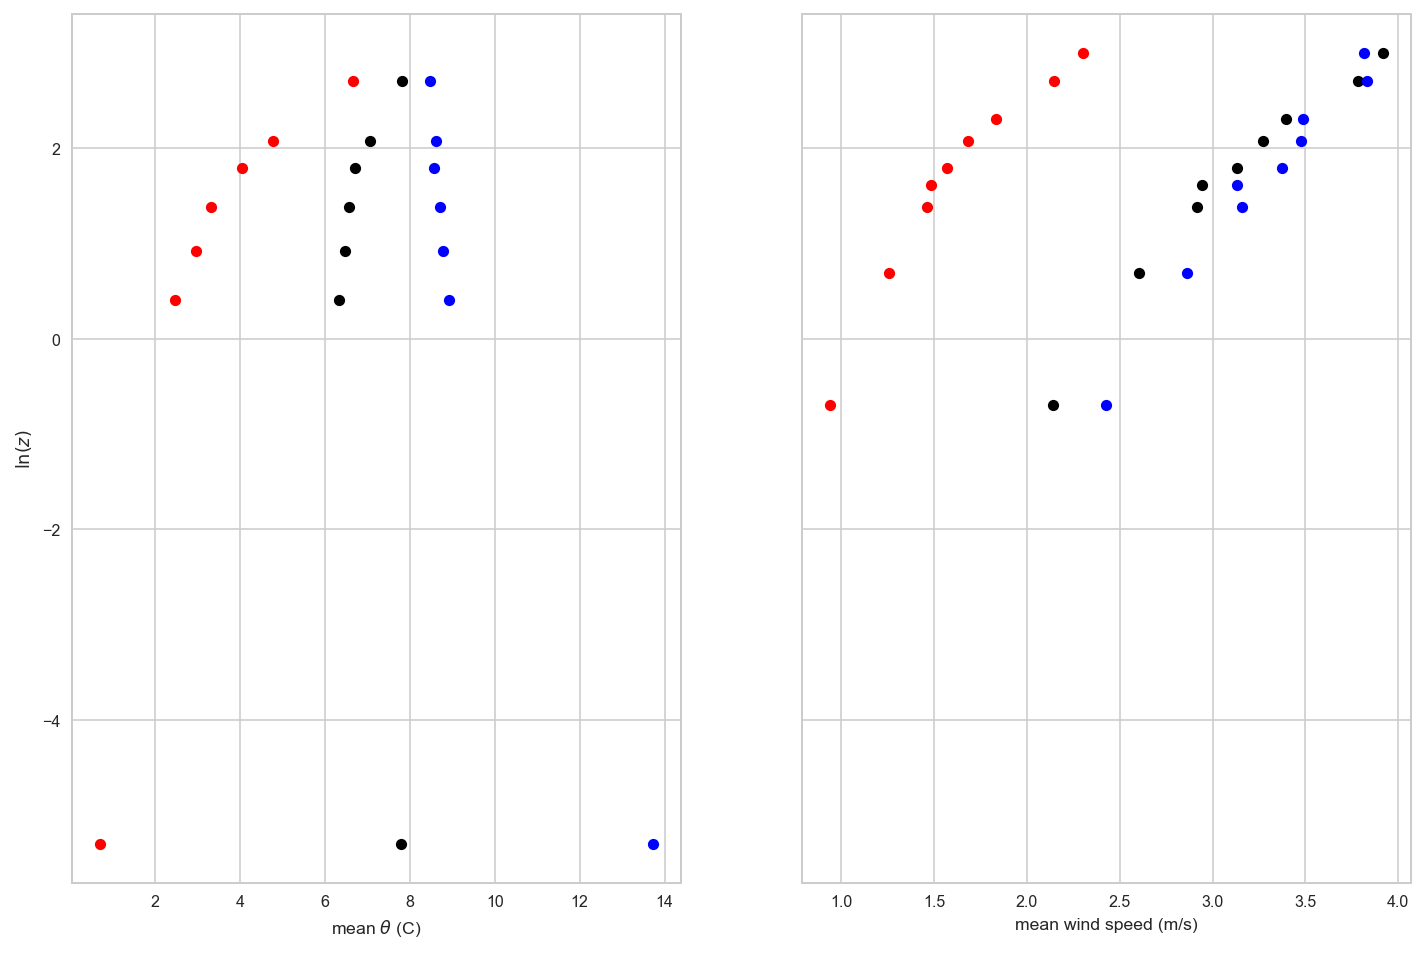

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8), sharey='row', sharex='col')
RiC = 0.2

# All conditions
ax = axes[0]
for t in thetaHeights:
    z = thetaHeights[t]
    ax.plot(Mtower[t].mean(dim='time'), np.log(z), 'o', color='k')

ax = axes[1]
for w in windHeights:
    z = windHeights[w]
    ax.plot(Mtower[w].mean(dim='time'), np.log(z), 'o', color='k')
    
# Just stable conditions
ax = axes[0]
for t in thetaHeights:
    z = thetaHeights[t]
    ax.plot(Mtower[t].where(Mtower['RiBulk_15.0m'] > RiC).mean(dim='time'), np.log(z), 'o', color='r')
    
ax = axes[1]
for w in windHeights:
    z = windHeights[w]
    ax.plot(Mtower[w].where(Mtower['RiBulk_15.0m'] > RiC).mean(dim='time'), np.log(z), 'o', color='r')

# Just unstable conditions
ax = axes[0]
for t in thetaHeights:
    z = thetaHeights[t]
    ax.plot(Mtower[t].where(Mtower['RiBulk_15.0m'] < 0).mean(dim='time'), np.log(z), 'o', color='b')
    
ax = axes[1]
for w in windHeights:
    z = windHeights[w]
    ax.plot(Mtower[w].where(Mtower['RiBulk_15.0m'] < 0).mean(dim='time'), np.log(z), 'o', color='b')

axes[1].set_xlabel('mean wind speed (m/s)')
axes[0].set_xlabel(r'mean $\theta$ (C)')
axes[0].set_ylabel(r'$\ln(z)$')

Profiles seem to have a shift in slope around z = 5m. I'll use T below 5m for the 2m estimate and T above 5m for the 10m estimate. 

Black is all observations, blue is just unstable (from 15m bulk Richardson), and red is stable (same RiBulk).

# Estimating a 2m and 10m air temperature

- Gradient fitting for the Obukhov length, L
- Estimate shear and temperature gradient with the gradients in $u$ and $\theta$ between each layer using the expression:

$\frac{\Delta u}{\Delta z} = \frac{1}{z_m} \frac{u_{z2} - u_{z1}}{ln(z2)-ln(z1)} $

where $z_m$ is the average of the log heights $\frac{ln(z1) + ln(z2)}{2}$ and $u$ can be exchanged with $\theta$.

Estimating the gradient Ri number:

$$
Ri = \frac{N^2}{s^2}
$$

where N and s are the Brunt-Vaisala frequency and shear, respectively. Both can be estimated using the gradient approach (above). Finally, L can be esimated as

$$
L = \frac{Ri}{z_m}
$$

I will use L estimated for z=2m using observations with $z \le 5m$ and for z=10m using observations with $z \ge 5m$. This will then be used to esimate L. Wind will come from the mean horizontal wind speed observed by the reference CSAT.

### Dropping the Obukhov length estimate

This turned out to be an extra convoluted process, especially since the $\theta$ and $U$ observations are offset from each other verically. So for calculating Ri I needed to find the average $N^2$ and average $s^2$ within the two internal boundary layers. Then I would use the gradient Richardson number calculated from the average boundary layer values, sampled at different heights with different numbers of observations, to esimate L at a single level (z = 2m). From there, I would still need to find the friction thermal length, $\theta*$, by assuming a stability function, neglecting bouyancy production and other effects. Finally, I would need to use the observed surface skin temperature, which sort of fits the boundary layer profile. But, I have a lot of doubts on how applicable the surface skin temperature is for calculating the gradient values.

Anyway, I am instead going to move forward with a linear regression against $\theta$ and $\ln{z}$, again with the same cut-off point of 5m.

(-0.5, 2)

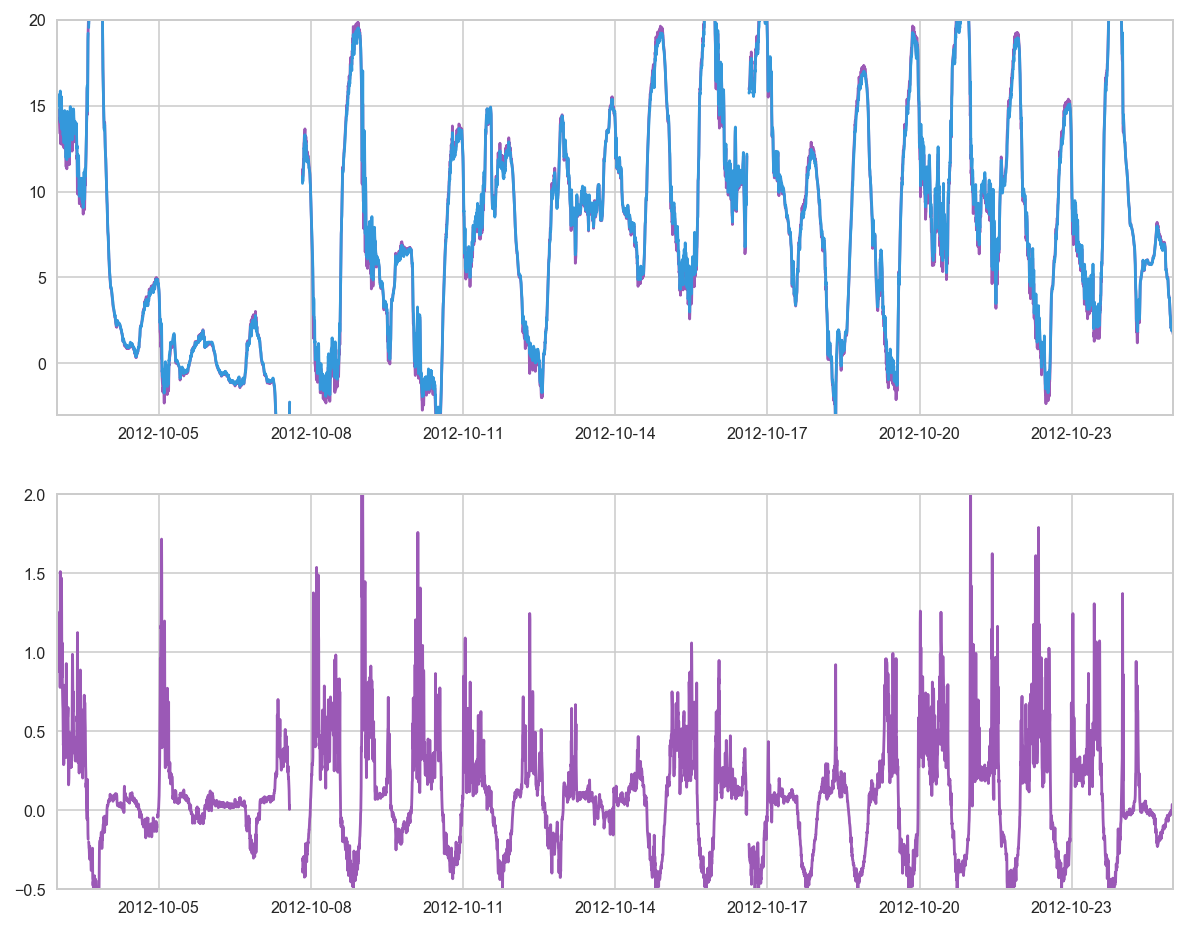

In [11]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

ax = axes[0]
ax.plot(Mtower.time, Mtower['T_1.5m'])
ax.plot(Mtower.time, Mtower['T_2.5m'])
ax.set_xlim(datetime(2012, 10, 3), datetime(2012, 10, 25))
ax.set_ylim(-3, 20)

ax = axes[1]
ax.plot(Mtower.time, (Mtower['T_2.5m'] - Mtower['T_1.5m']) / 1.)
ax.set_xlim(datetime(2012, 10, 3), datetime(2012, 10, 25))
ax.set_ylim(-0.5, 2)

(-0.5, 2)

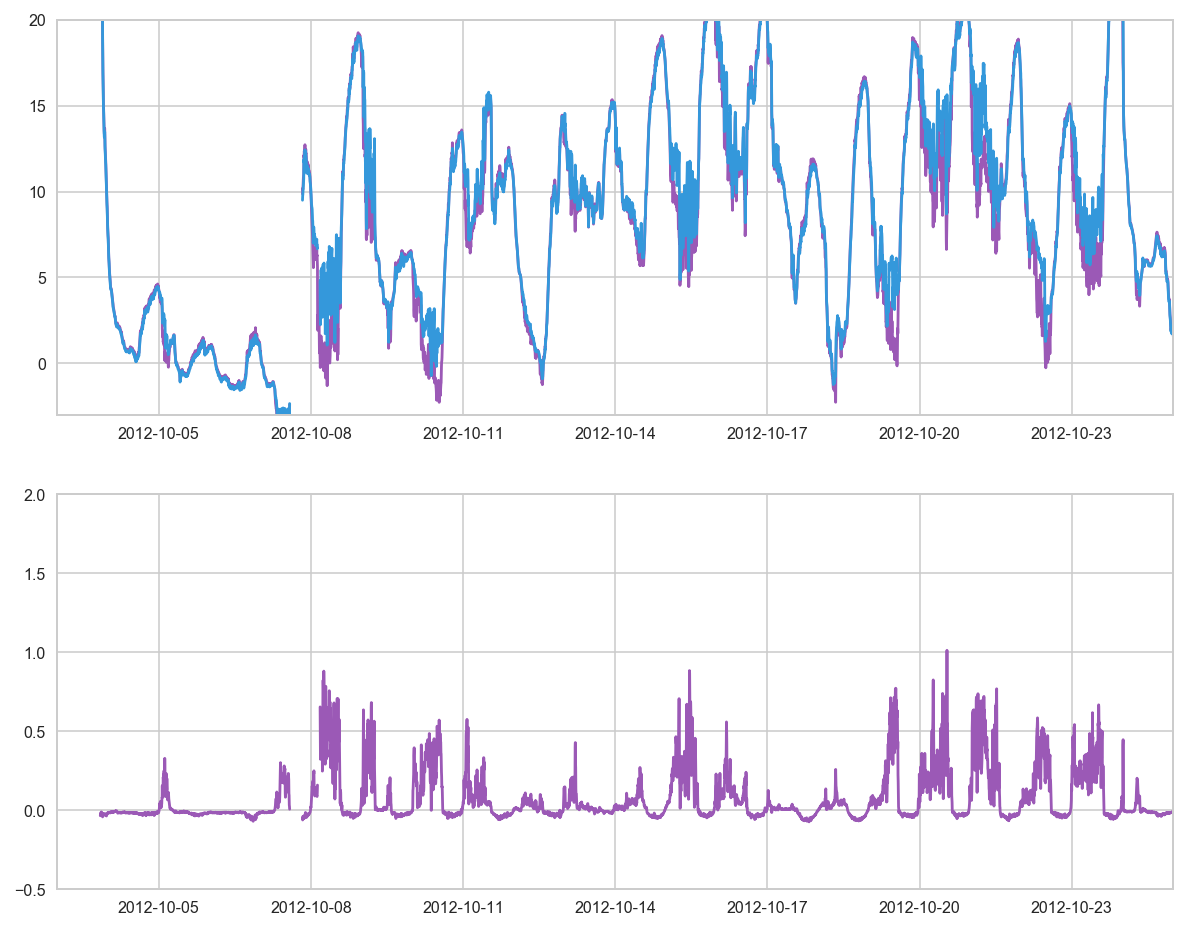

In [12]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

ax = axes[0]
ax.plot(Mtower.time, Mtower['T_8m'])
ax.plot(Mtower.time, Mtower['T_15m'])
ax.set_xlim(datetime(2012, 10, 3), datetime(2012, 10, 25))
ax.set_ylim(-3, 20)

ax = axes[1]
ax.plot(Mtower.time, (Mtower['T_15m'] - Mtower['T_8m']) / 7.)
ax.set_xlim(datetime(2012, 10, 3), datetime(2012, 10, 25))
ax.set_ylim(-0.5, 2)

Largest differences at night between observations. The gradient is approximately the same order of magnitude between the two levels, making me feel _ok_ about using the linear regression.

/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:973: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


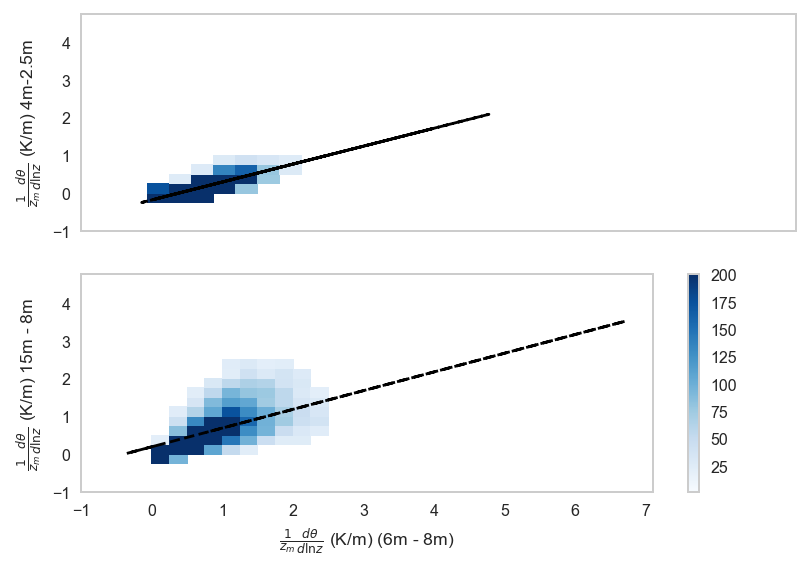

In [13]:
########
# 2m

# Theta
theta_low_names = {'T_1.5m': 1.5,
                   'T_2.5m': 2.5,
                   'T_4m': 4.0}

# Height variables
theta_low_z = [1.5, 2.5, 4.0]
lnz_low = np.log(theta_low_z)
lnzm_low = 0.5 * (lnz_low[0:-1] + lnz_low[1:])
zm_low = np.exp(lnzm_low)

# Gather a matrix of u and theta for each case
theta_low = np.zeros((Mtower.T_15m.size, np.size(theta_low_z)))
for nz, t in enumerate(theta_low_names):
    theta_low[:, nz] = Mtower[t]
dthetadz = np.diff(theta_low, 1) / (zm_low * np.diff(lnz_low))

slope_low, intercept_low, r_value_low, p_value, std_err = stats.linregress(dthetadz[(Mtower['RiBulk_4.0m'] > 0)
                                                                                & (~np.isnan(dthetadz[:, 0]))
                                                                                & (~np.isnan(dthetadz[:, 1])), 0],
                                                                       dthetadz[(Mtower['RiBulk_4.0m'] > 0)
                                                                                & (~np.isnan(dthetadz[:, 0]))
                                                                                & (~np.isnan(dthetadz[:, 1])), 1])

fig, axes = plt.subplots(2, 1, sharex=True)

ax = axes[0]
cmin = 1
cmax = 200
ncol = 11
dcol = (cmax-cmin)/(ncol-1)
cmap = cm.Blues
H, xedges, yedges = np.histogram2d(dthetadz[Mtower['RiBulk_15.0m'] > 0, 0],
                                   dthetadz[Mtower['RiBulk_15.0m'] > 0, 1],
                                   bins=(np.arange(-1, 5, .25), np.arange(-1, 5, .25)))
H = np.ma.masked_array(H, H < cmin+dcol)
X, Y = np.meshgrid(xedges, yedges)
im = ax.pcolormesh(X.T, Y.T, H,cmap=cmap,vmin=cmin,vmax=cmax)
ax.plot(dthetadz[Mtower['RiBulk_15.0m'] > 0, 0],
        dthetadz[Mtower['RiBulk_15.0m'] > 0, 0] * slope_low + intercept_low, 'k--')

ax.set_ylabel(r'$\frac{1}{z_m}\frac{d\theta}{d\ln{z}}$ (K/m) 4m-2.5m')

########
# 10m

# Theta
theta_high_names = {'T_6m': 6.0,
                   'T_8m': 8.0,
                   'T_15m': 15.0
                   }

# Height variables
theta_high_z = [6., 8., 15.]
lnz_high = np.log(theta_high_z)
lnzm_high = 0.5 * (lnz_high[0:-1] + lnz_high[1:])
zm_high = np.exp(lnzm_high)

# Gather a matrix of u and theta for each case
theta_high = np.zeros((Mtower.T_15m.size, np.size(theta_high_z)))
for nz, t in enumerate(theta_high_names):
    theta_high[:, nz] = Mtower[t]
dthetadz = np.diff(theta_high, 1) / (zm_low * np.diff(lnz_high))

slope_high, intercept_high, r_value, p_value, std_err = stats.linregress(dthetadz[Mtower['RiBulk_15.0m'] > 0, 0],
                                                                         dthetadz[Mtower['RiBulk_15.0m'] > 0, 1])

ax = axes[1]
cmin = 1
cmax = 200
ncol = 11
dcol = (cmax-cmin)/(ncol-1)
cmap = cm.Blues
H, xedges, yedges = np.histogram2d(dthetadz[Mtower['RiBulk_15.0m'] > 0, 0],
                                   dthetadz[Mtower['RiBulk_15.0m'] > 0, 1],
                                   bins=(np.arange(-1, 5, .25), np.arange(-1, 5, .25)))
H = np.ma.masked_array(H, H < cmin+dcol)
X, Y = np.meshgrid(xedges, yedges)
im = ax.pcolormesh(X.T, Y.T, H,cmap=cmap,vmin=cmin,vmax=cmax)
ax.plot(dthetadz[Mtower['RiBulk_15.0m'] > 0, 0],
        dthetadz[Mtower['RiBulk_15.0m'] > 0, 0] * slope_high + intercept_high, 'k--')

ax.set_ylabel(r'$\frac{1}{z_m}\frac{d\theta}{d\ln{z}}$ (K/m) 15m - 8m')
ax.set_xlabel(r'$\frac{1}{z_m}\frac{d\theta}{d\ln{z}}$ (K/m) (6m - 8m)')
fig.colorbar(im)

So the r values are around 0.58 for the upper and 0.78 for the lower temperatures. Not great, but hey, let's try to move on with our lives.

In [14]:
# 2m estimate
theta_low_names = {'T_1.5m': 1.5,
                   'T_2.5m': 2.5,
                   'T_4m': 4.0,
                   'T_6m': 6.0}

# Height variables
theta_low_z = [1.5, 2.5, 4.0, 6.0]

slope_low = np.zeros_like(Mtower.T_1_5m_M)
intercept_low = np.zeros_like(Mtower.T_1_5m_M)
theta_2m = np.zeros_like(Mtower.T_1_5m_M)
for nt, t in enumerate(Mtower.time):
    theta_low = np.zeros_like(theta_low_z)
    
    for nz, tname in enumerate(theta_low_names):
        theta_low[nz] = Mtower[tname].sel(time=t)
    
    slope_low[nt], intercept_low[nt], _, _, _ = stats.linregress(np.log(theta_low_z), theta_low)

    theta_2m[nt] = slope_low[nt] * np.log(2) + intercept_low[nt]
    

(-0.5, 2)

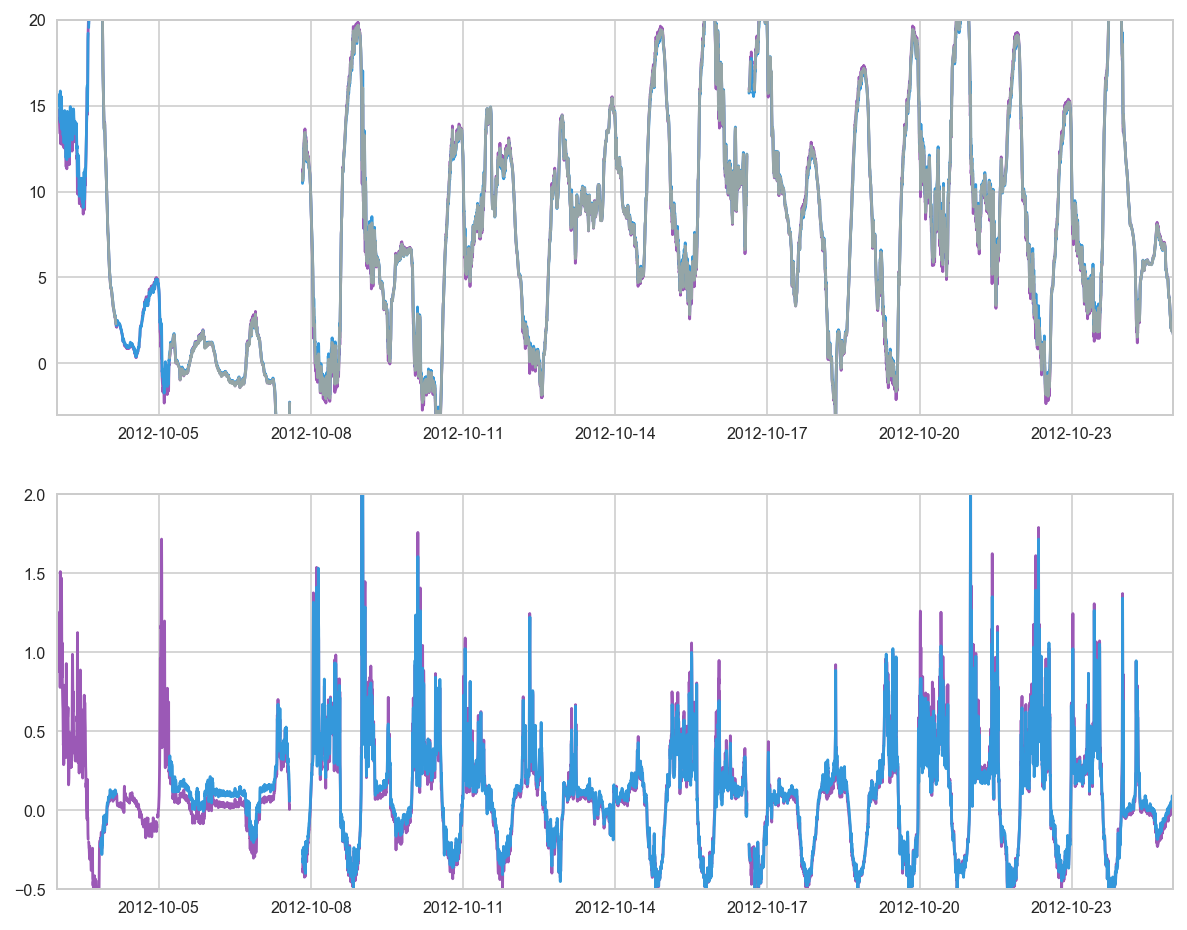

In [15]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

ax = axes[0]
ax.plot(Mtower.time, Mtower['T_1.5m'])
ax.plot(Mtower.time, Mtower['T_2.5m'])
ax.plot(Mtower.time, theta_2m)
ax.set_xlim(datetime(2012, 10, 3), datetime(2012, 10, 25))
ax.set_ylim(-3, 20)

ax = axes[1]
ax.plot(Mtower.time, (Mtower['T_2.5m'] - Mtower['T_1.5m']) / 1.)
ax.plot(Mtower.time, (Mtower['T_2.5m'] - theta_2m) / 0.5)
ax.set_xlim(datetime(2012, 10, 3), datetime(2012, 10, 25))
ax.set_ylim(-0.5, 2)

In [16]:
# 10m estimate
theta_high_names = {'T_4m': 4.0,
                    'T_6m': 6.0,
                    'T_8m': 8.0,
                    'T_15m': 15.0
                   }

# Height variables
theta_high_z = [4., 6., 8., 15.]
slope_high = np.zeros_like(Mtower.T_1_5m_M)
intercept_high = np.zeros_like(Mtower.T_1_5m_M)
theta_10m = np.zeros_like(Mtower.T_1_5m_M)
for nt, t in enumerate(Mtower.time):
    theta_high = np.zeros_like(theta_high_z)
    
    for nz, tname in enumerate(theta_high_names):
        theta_high[nz] = Mtower[tname].sel(time=t)
    
    slope_high[nt], intercept_high[nt], _, _, _ = stats.linregress(np.log(theta_high_z), theta_high)

    theta_10m[nt] = slope_high[nt] * np.log(10) + intercept_high[nt]

(-0.5, 2)

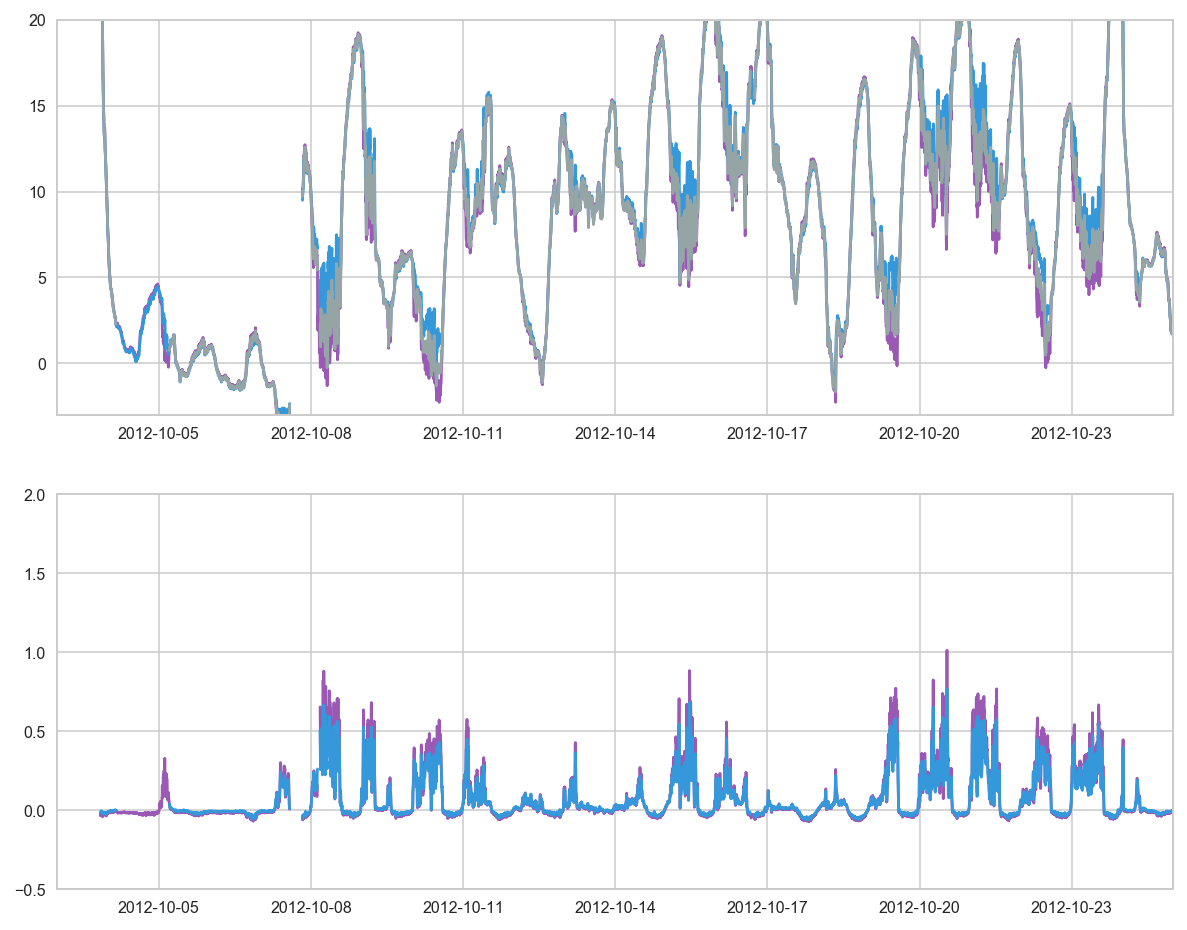

In [17]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

ax = axes[0]
ax.plot(Mtower.time, Mtower['T_8m'])
ax.plot(Mtower.time, Mtower['T_15m'])
ax.plot(Mtower.time, theta_10m)
ax.set_xlim(datetime(2012, 10, 3), datetime(2012, 10, 25))
ax.set_ylim(-3, 20)

ax = axes[1]
ax.plot(Mtower.time, (Mtower['T_15m'] - Mtower['T_8m']) / 7.)
ax.plot(Mtower.time, (Mtower['T_15m'] - theta_10m) / 5.)
ax.set_xlim(datetime(2012, 10, 3), datetime(2012, 10, 25))
ax.set_ylim(-0.5, 2)

## Create the new data sets for use in simulations

In [19]:
theta_2m = xr.DataArray(theta_2m,
                        coords={'time': Mtower.time},
                        dims=['time'])

theta_10m = xr.DataArray(theta_10m,
                        coords={'time': Mtower.time},
                        dims=['time'])

Mtower['theta_2m'] = ('time', theta_2m)
Mtower['theta_10m'] = ('time', theta_10m)

os.chdir(dir_scp)
Mtower.to_netcdf('SCP.Mtower_pottemps.nc')

## Compare to the temperature gradient I was using previously

-1.59412208579


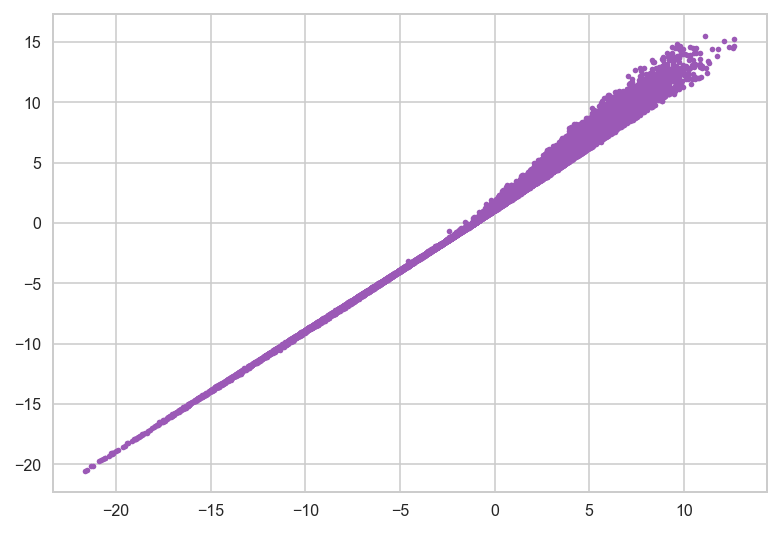

In [36]:
Tsfc_old = (radObs.Rlw_out / (sigma))**(1. / 4.)
T15m = Mtower['T_15m_M']

plt.plot(Mtower.theta_10m - Mtower.Tsfc, T15m - (Tsfc_old - 273), '.')
print(np.nanmean((Mtower.theta_10m - Mtower.Tsfc) - (T15m - (Tsfc_old - 273))))

So now the temperature gradient is on average 1.5 degrees smaller than before.